In [1]:
import numpy as np
import cv2
from skimage.io import imread
from utils import data_loader
import scipy
import scipy.io as io
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

In [2]:
mask_size = (192, 256)
mask = np.zeros(mask_size)
mask_ = imread('examples/Image10.png', as_gray=True)

In [3]:
mask = data_loader.mapping_rescale_dot(mask, mask_)

In [4]:
non_zero_points = np.array(np.nonzero(mask))
non_zero_points = np.transpose(non_zero_points)

In [5]:
non_zero_points

array([[ 34, 183],
       [ 41, 165],
       [ 42, 154],
       [ 47, 181],
       [ 52, 138],
       [ 55, 158],
       [ 58, 118],
       [ 65, 134],
       [ 83, 135]])

In [6]:
np.fliplr(non_zero_points)

array([[183,  34],
       [165,  41],
       [154,  42],
       [181,  47],
       [138,  52],
       [158,  55],
       [118,  58],
       [134,  65],
       [135,  83]])

In [38]:
def gaussian_filter_density(ground_truth_img, points, k_nearest=4, beta=0.3, leafsize=2048, fixed_sigma=None):
    '''
    This code use k-nearst, will take one minute or more to generate a density-map with one thousand people.
    points: a two-dimension list of pedestrians' annotation with the order [[col,row],[col,row],...].
    img_shape: the shape of the image, same as the shape of required density-map. (row,col). Note that can not have channel.
    return:
    density: the density-map we want. Same shape as input image but only has one channel.
    example:
    points: three pedestrians with annotation:[[163,53],[175,64],[189,74]].
    img_shape: (768,1024) 768 is row and 1024 is column.
    '''
    img_shape = [ground_truth_img.shape[0], ground_truth_img.shape[1]]
    print("Shape of current image: ", img_shape, ". Totally need generate ", len(points), "gaussian kernels.")
    density = np.zeros(img_shape, dtype=np.float32)
    gt_count = len(points)
    if gt_count == 0:
        return density

    # build kdtree
    tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(points, k=k_nearest)

    print('generate density...')
    for i, pt in enumerate(points):
        pt2d = np.zeros(img_shape, dtype=np.float32)
        if int(pt[1]) < img_shape[0] and int(pt[0]) < img_shape[1]:
            pt2d[int(pt[1]), int(pt[0])] = 1.
        else:
            continue
        if gt_count > 1:
            sigma = (np.average(distances[i][1: k_nearest + 1])) * beta
        else:
            sigma = np.average(np.array(pt.shape)) / 2. / 2.  #case: 1 point
        if fixed_sigma is not None:
            sigma = fixed_sigma
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [29]:
test = [0,1,2,3,4]
print(test[1:3 + 1])

[1, 2, 3]


In [14]:
mask.shape

(192, 256)

In [39]:
dm = gaussian_filter_density(mask, np.fliplr(non_zero_points), k_nearest=3, fixed_sigma=10)

Shape of current image:  [192, 256] . Totally need generate  9 gaussian kernels.
generate density...
done.


In [40]:
dm.shape

(192, 256)

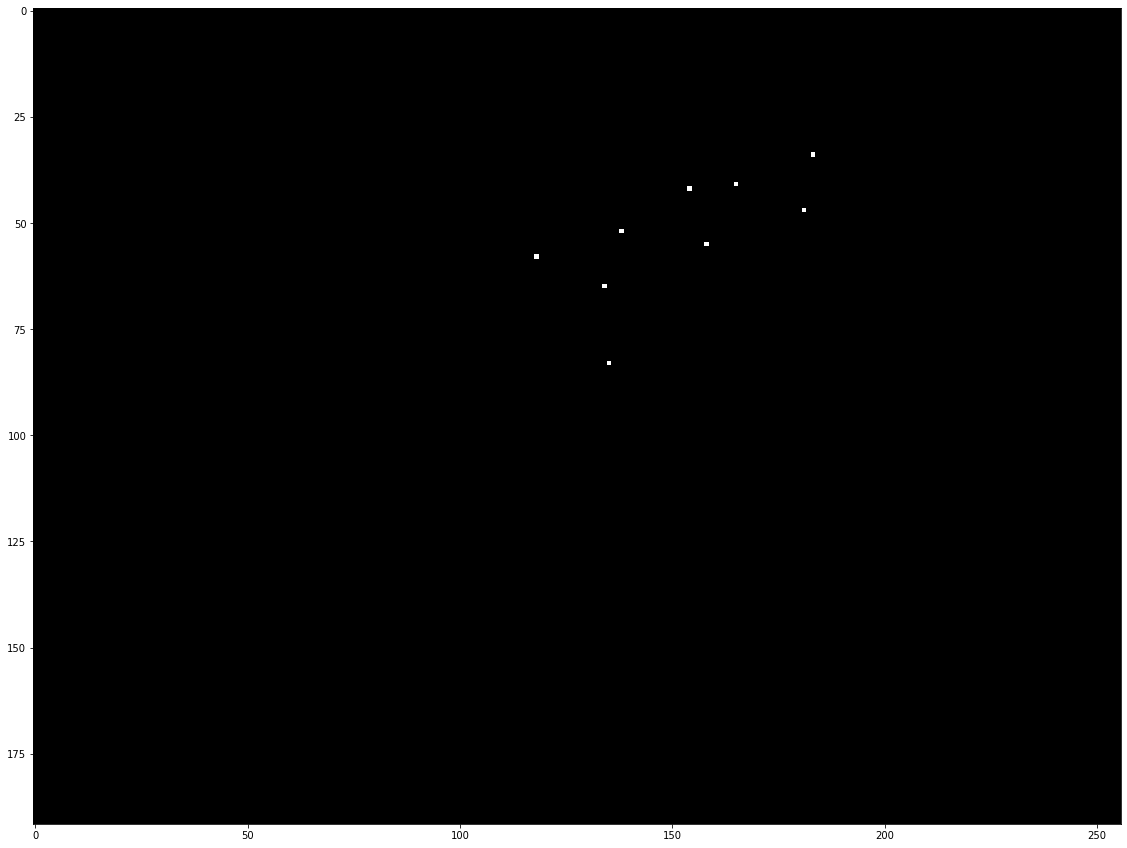

In [41]:
plt.figure(figsize=(30, 15))
plt.imshow(mask, cmap='gray')
plt.show()

In [42]:
np.sum(dm)

8.999747

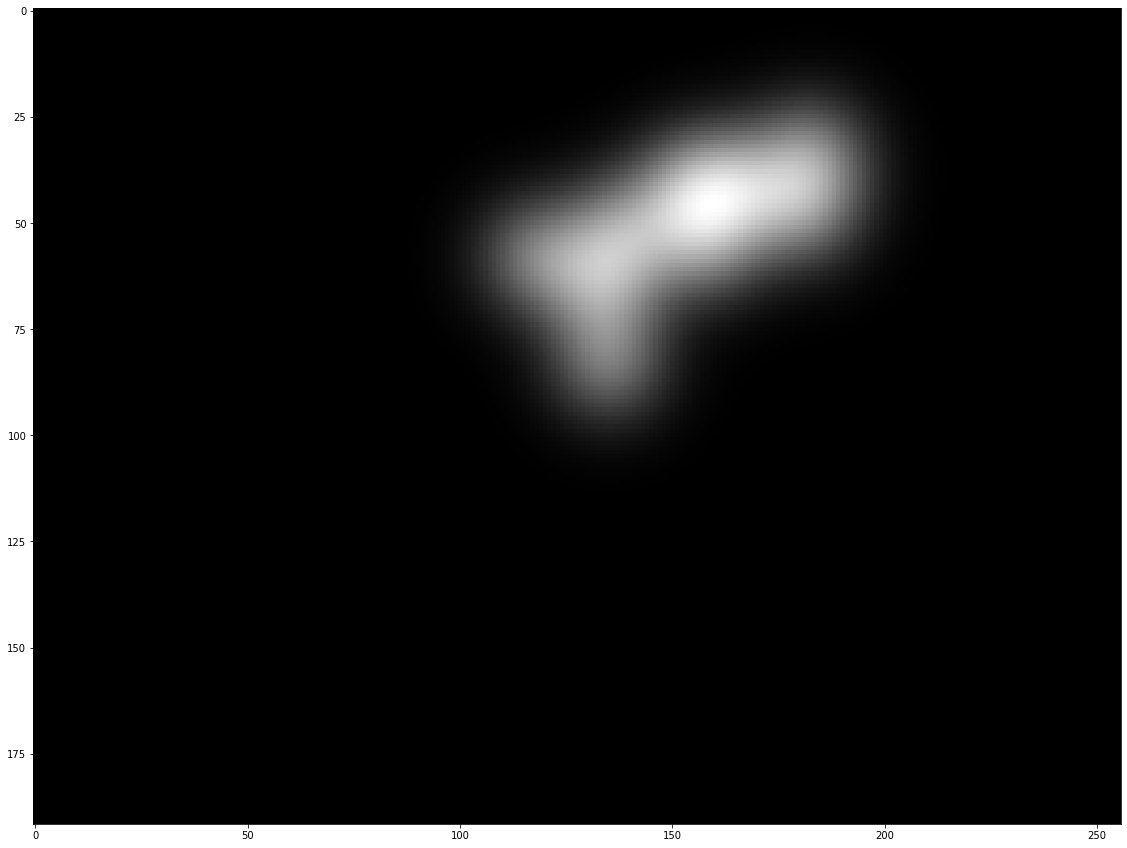

In [43]:
plt.figure(figsize=(30, 15))
plt.imshow(dm, cmap='gray')
plt.show()